# Problem Set 1
## Members
    - Edmundo Arias – 202110688
    - Lucia Maldonado –
    - Juan Diego Heredia –

### Date: September something, 2024

# 0. Set Up

In [2]:
### Start

# clear environment and load libraries
rm(list = ls())
# nolint start

# install and load required packages
packages <- c(
    "tidyverse", "ggplot2", "stargazer",
    "rvest", "dplyr", "httr", "boot", "broom",
    "lmtest", "fixest", "sandwich", "lmtest", 
    "parallel", "foreach", "doParallel",
    "future.apply", "caret"
)
invisible(lapply(packages, function(pkg) {
    if (!requireNamespace(pkg, quietly = TRUE)) install.packages(pkg)
    library(pkg, character.only = TRUE)
}))

# 1. Data

In [2]:
plan(multisession) # Paralellizing

# scraping function
scrape_page <- function(url) {
  response <- GET(url)
  if (status_code(response) != 200) {
    warning(paste("Failed to retrieve page:", url)) 
    return(NULL) 
  }
  content <- content(response, "text")
  page <- read_html(content)
  include_element <- html_node(page, "[w3-include-html]")
  include_url <- html_attr(include_element, "w3-include-html")
  full_include_url <- paste0("https://ignaciomsarmiento.github.io/GEIH2018_sample/", include_url)
  included_content <- read_html(full_include_url)
  df_page <- html_node(included_content, "table") %>% html_table()
  return(df_page)
}

In [3]:
base_url <- "https://ignaciomsarmiento.github.io/GEIH2018_sample/page"

# Use future_lapply to run tasks asynchronously -> gracias Ignacio :)
df_list <- future_lapply(1:10, function(i) {
  url <- paste0(base_url, i, ".html")
  df_page <- scrape_page(url)
  if (!is.null(df_page)) print(paste("Successfully scraped page", i))
  return(df_page)
})
df_list <- Filter(Negate(is.null), df_list)

# combine
df <- do.call(rbind, df_list)

[1] "Successfully scraped page 1"
[1] "Successfully scraped page 2"
[1] "Successfully scraped page 3"
[1] "Successfully scraped page 4"
[1] "Successfully scraped page 5"
[1] "Successfully scraped page 6"
[1] "Successfully scraped page 7"
[1] "Successfully scraped page 8"
[1] "Successfully scraped page 9"
[1] "Successfully scraped page 10"


In [4]:
dim(df)

[1] 32177   178

In [5]:
#TODO: interpret

# 2. Age-Wage Analysis

## 2.1. Prep Data

In [15]:
# prep data
df <- df[df$age > 18 & df$ocu == 1, ]
names(df) <- make.names(names(df), unique = TRUE) # set df names

# drop missing wages; log transform
df <- df %>%
    filter(!is.na(y_ingLab_m), !is.na(age)) %>%
    mutate(log_wage = log(y_ingLab_m + 1))


## 2.2. Model Estimation

In [16]:
# fit OLS model
model <- lm(log_wage ~ age + I(age^2), data = df)
print(summary(model))


Call:
lm(formula = log_wage ~ age + I(age^2), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7449 -0.3833 -0.1060  0.3007  3.8503 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.238e+01  7.335e-02  168.73   <2e-16 ***
age          8.509e-02  3.878e-03   21.94   <2e-16 ***
I(age^2)    -9.880e-04  4.773e-05  -20.70   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7423 on 9782 degrees of freedom
Multiple R-squared:  0.05007,	Adjusted R-squared:  0.04988 
F-statistic: 257.8 on 2 and 9782 DF,  p-value: < 2.2e-16



## 2.3. Bootstrap SE's

In [17]:
# f to apply bootstrap to regression estimates
boot_fn <- function(data, indices) {
    d <- data[indices, ]
    fit <- lm(log_wage ~ age + I(age^2), data = d)
    coef <- coef(fit)
    peak_age <- -coef[2] / (2 * coef[3])
    return(c(coef, peak_age = peak_age))
}

# f that calculates peak age (see model)
calc_peak_age <- function(data, indices) {
    d <- data[indices, ]
    model <- lm(log_wage ~ age + I(age^2), data = d)
    coef <- coef(model)
    peak_age <- -coef[2] / (2 * coef[3])
    return(peak_age)
}

# bootstrap
set.seed(555)
boot_results <- boot(data = df, statistic = boot_fn, R = 1000)

boot_se <- apply(boot_results$t, 2, sd)

In [9]:
#TODO: add math and peak age equation (see old rmd file)

# 2.4. Results

### Table

In [18]:
stargazer(model,
    se = list(boot_se), type = "text",
    title = "Age-Wage Profile Regression Results",
    column.labels = c("Coefficients", "Bootstrap SE")
)

# peak age & CI's
original_peak_age <- -coef(model)[2] / (2 * coef(model)[3])
ci_peak <- quantile(boot_results$t[, 4], c(0.025, 0.975))

cat("\nPeak Age Analysis:\n")
cat("Estimated Peak Age:", round(original_peak_age, 2), "\n")
cat(
    "95% CI for Peak Age:", round(ci_peak[1], 2),
    "to", round(ci_peak[2], 2), "\n\n"
)


Age-Wage Profile Regression Results
                        Dependent variable:    
                    ---------------------------
                             log_wage          
                           Coefficients        
-----------------------------------------------
age                          0.085***          
                              (0.005)          
                                               
I(age2)                      -0.001***         
                             (0.0001)          
                                               
Constant                     12.376***         
                              (0.084)          
                                               
-----------------------------------------------
Observations                   9,785           
R2                             0.050           
Adjusted R2                    0.050           
Residual Std. Error      0.742 (df = 9782)     
F Statistic          257.797*** (df = 2; 9782) 
Not

In [11]:
#TODO: interpret

### Plot

In [12]:
# install.packages("IRkernel")
# IRkernel::installspec() 

In [19]:
temp_dir <- "~/R_temp"
dir.create(temp_dir, showWarnings = FALSE, recursive = TRUE)
Sys.setenv(TMPDIR = temp_dir)

png(filename = paste0(temp_dir, "/plot.png"))

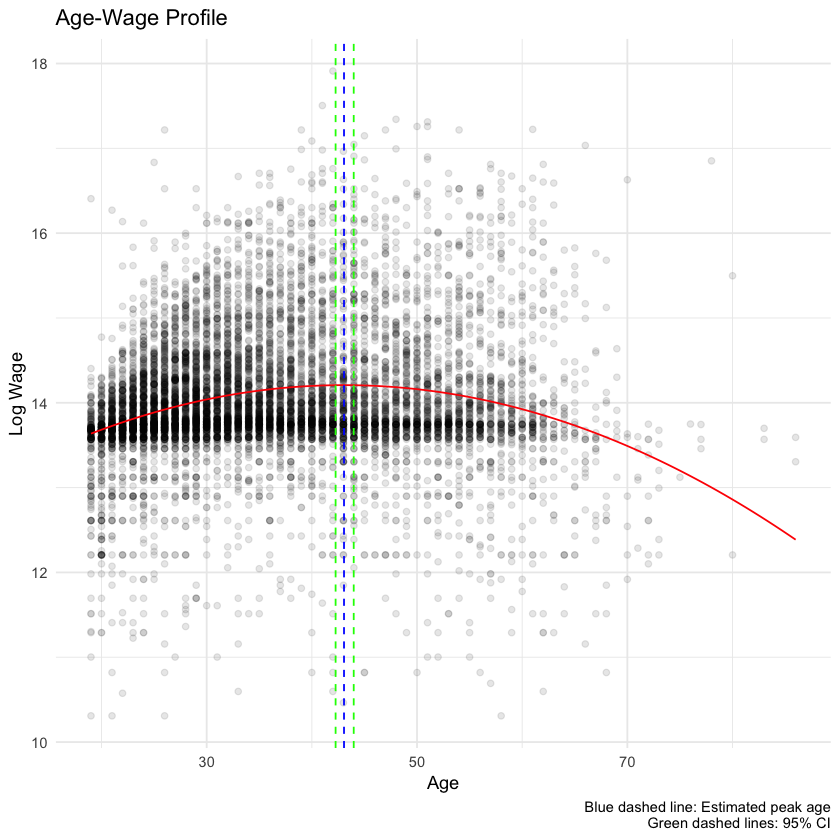

In [20]:
new_data <- data.frame(age = seq(min(df$age), max(df$age), length.out = 100))
new_data$predicted_log_wage <- predict(model, newdata = new_data)

ggplot(df, aes(x = age, y = log_wage)) +
  geom_point(alpha = 0.1) +
  geom_line(data = new_data, aes(x = age, y = predicted_log_wage), color = "red") +
  geom_vline(xintercept = original_peak_age, color = "blue", linetype = "dashed") +
  geom_vline(xintercept = ci_peak[1], color = "green", linetype = "dashed") +
  geom_vline(xintercept = ci_peak[2], color = "green", linetype = "dashed") +
  labs(
    title = "Age-Wage Profile",
    x = "Age",
    y = "Log Wage",
    caption = "Blue dashed line: Estimated peak age\nGreen dashed lines: 95% CI"
  ) +
  theme_minimal()

# 3. Gender Earnings GAP

## 3.1. Unconditional GAP

In [21]:
model_gap <- lm(log_wage ~ sex, data = df)
robust_se <- vcovHC(model_gap, type = "HC1") # heteroskedasticity robust SE
robust_summary <- coeftest(model_gap, vcov = robust_se)
print(robust_summary)


t test of coefficients:

             Estimate Std. Error   t value  Pr(>|t|)    
(Intercept) 13.948138   0.011551 1207.5540 < 2.2e-16 ***
sex          0.151050   0.015329    9.8536 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [16]:
#TODO: interpret --> 15% avg. wage gap


## 3.2. Conditional GAP

### 3.2.1. Standard SE

In [22]:
# define control variables
controls <- c("age", "oficio", "p6210", "relab", "hoursWorkUsual")
## --> "p6220" refers to education attainment

# i) FWL: Standard SE's
formula_controls <- as.formula(paste(
    "log_wage ~",
    paste(controls, collapse = " + ")
))
formula_controls_sex <- as.formula(paste(
    "sex ~",
    paste(controls, collapse = " + ")
))

# partial out  controls
residuals_y <- feols(formula_controls, data = df)$residuals
residuals_sex <- feols(formula_controls_sex, data = df)$residuals

# regress residuals
fwl_model <- lm(residuals_y ~ residuals_sex)

# stats
fwl_coef <- coef(fwl_model)[2]
fwl_se <- sqrt(vcov(fwl_model)[2, 2])


### 3.2.2. Bootstrap SE

In [23]:
# remember our old f?
boot_fwl <- function(data, indices) {
    resid_y <- residuals_y[indices]
    resid_sex <- residuals_sex[indices]
    boot_model <- lm(resid_y ~ resid_sex)
    return(coef(boot_model)[2])
}

# bootstrap
set.seed(555)
boot_results <- boot(data = df, statistic = boot_fwl, R = 5000)

# bootstrap standard error
boot_se <- sd(boot_results$t)

### 3.2.3. Results

In [24]:
results_df <- data.frame(
    Term = c("Coefficient", "Standard Error (Normal)", "Standard Error (Bootstrap)"),
    Estimate = c(fwl_coef, fwl_se, boot_se)
)

stargazer(
  results_df,
  type = "text",
  summary = FALSE,
  rownames = FALSE,
  title = "Frisch-Waugh-Lovell Theorem Results",
  covariate.labels = c("Coefficient", "Statistic", "Standard Error (Bootstrap)"), # Keep original row labels
  coef = list(results_df$Estimate),
  digits = 5,
  notes = "Bootstrap standard errors are based on 1000 replications",
  out = "results_table.txt"
)

table_text <- readLines("results_table.txt")
table_text <- gsub("Standard Error \\(Normal\\)", "Statistic", table_text, fixed = FALSE)



Frisch-Waugh-Lovell Theorem Results
Coefficient                                Statistic     
---------------------------------------------------------
Coefficient                                 0.22470      
Standard Error (Normal)                     0.01312      
Standard Error (Bootstrap)                  0.01314      
---------------------------------------------------------
Bootstrap standard errors are based on 1000 replications 


### Plot 
Q: How should we do this plot? Conditional on what? If yes, which variables?

In [20]:
#TODO

In [21]:
#TODO: interpret

# 4. Predicting Wage

## 4.1. Sample Split

In [26]:
set.seed(555)

n <- nrow(df)
train_indices <- sample(1:n, size = 0.7 * n, replace = FALSE)

train_data <- df[train_indices, ]  # Training set (70%)
test_data <- df[-train_indices, ]  # Test set (30%)

cat("Training Set Size:", nrow(train_data), "\n")
cat("Testing Set Size:", nrow(test_data), "\n")

Training Set Size: 6849 
Testing Set Size: 2936 


## 4.2. Model Specification & Estimation

### 4.2.1. Using Least Squares

In [27]:
# outcome and controls/predictors 
outcome <- "log_wage"
controls <- c("age", "oficio", "p6210", "relab", "hoursWorkUsual", "sex") # vector of covariates chosen

# f to calculate RMSE
calculate_rmse <- function(actual, predicted) {
  sqrt(mean((actual - predicted)^2))
}

# train & test sets
train_data <- df[train_indices, ]
test_data <- df[-train_indices, ]


### Model 1:

\begin{equation}
\log(\text{wage}) = \beta_0 + \beta_1 \cdot \text{age} + \beta_2 \cdot \text{age}^2 + \beta_3 \cdot \text{sex} + \epsilon \tag{1}
\end{equation}

### Model 2:

\begin{equation}
\log(\text{wage}) = \beta_0 + \beta_1 \cdot \text{age} + \beta_2 \cdot \text{age}^2 + \beta_3 \cdot \text{sex} + \beta_4 \cdot \text{p6210} + \beta_5 \cdot (\text{age} \times \text{sex}) + \epsilon \tag{2}
\end{equation}

### Model 3:

\begin{equation}
\log(\text{wage}) = \beta_0 + \beta_1 \cdot \text{age} + \beta_2 \cdot \text{age}^2 + \beta_3 \cdot \text{sex} + \beta_4 \cdot \text{p6210} + \beta_5 \cdot \text{oficio} + \beta_6 \cdot \text{hoursWorkUsual} + \beta_7 \cdot \text{hoursWorkUsual}^2 + \beta_8 \cdot (\text{age} \times \text{sex}) + \epsilon \tag{3}
\end{equation}

### Model 4:

\begin{equation}
\log(\text{wage}) = \beta_0 + \beta_1 \cdot \text{age} + \beta_2 \cdot \text{age}^2 + \beta_3 \cdot \text{sex} + \beta_4 \cdot \text{p6210} + \beta_5 \cdot \text{oficio} + \beta_6 \cdot \text{hoursWorkUsual} + \beta_7 \cdot \text{hoursWorkUsual}^2 + \beta_8 \cdot \text{relab} + \beta_9 \cdot (\text{age} \times \text{sex}) + \beta_{10} \cdot (\text{p6210} \times \text{oficio}) + \epsilon \tag{4}
\end{equation}

### Model 5:

\begin{equation}
\log(\text{wage}) = \beta_0 + \beta_1 \cdot \text{age} + \beta_2 \cdot \text{age}^2 + \beta_3 \cdot \text{sex} + \beta_4 \cdot \text{p6210} + \beta_5 \cdot \text{oficio} + \beta_6 \cdot \text{hoursWorkUsual} + \beta_7 \cdot \text{hoursWorkUsual}^2 + \beta_8 \cdot \text{relab} + \beta_9 \cdot (\text{age} \times \text{sex}) + \beta_{10} \cdot (\text{p6210} \times \text{oficio}) + \beta_{11} \cdot (\text{relab} \times \text{hoursWorkUsual}) + \epsilon \tag{5}
\end{equation}


In [28]:
# Model 1: age, sex, and a second-order polynomial of age
model_1 <- lm(log_wage ~ poly(age, 2) + sex, data = train_data)
pred_1 <- predict(model_1, newdata = test_data)
rmse_1 <- calculate_rmse(test_data[[outcome]], pred_1)

# Model 2: add education (p6210) and interaction between age and sex
model_2 <- lm(log_wage ~ poly(age, 2) + sex + p6210 + age:sex, data = train_data)
pred_2 <- predict(model_2, newdata = test_data)
rmse_2 <- calculate_rmse(test_data[[outcome]], pred_2)

# Model 3: add occupation (oficio), work hours (hoursWorkUsual), and a second-order polynomial for work hours
model_3 <- lm(log_wage ~ poly(age, 2) + sex + p6210 + oficio + poly(hoursWorkUsual, 2) + age:sex, data = train_data)
pred_3 <- predict(model_3, newdata = test_data)
rmse_3 <- calculate_rmse(test_data[[outcome]], pred_3)

# Model 4: add employment relationship (relab) and interactions between education and occupation
model_4 <- lm(log_wage ~ poly(age, 2) + sex + p6210 + oficio + poly(hoursWorkUsual, 2) + relab + 
                age:sex + p6210:oficio, data = train_data)
pred_4 <- predict(model_4, newdata = test_data)
rmse_4 <- calculate_rmse(test_data[[outcome]], pred_4)

# Model 5: full model with all variables, interactions, and polynomials
model_5 <- lm(log_wage ~ poly(age, 2) + sex + p6210 + oficio + poly(hoursWorkUsual, 2) + relab + 
                age:sex + p6210:oficio + relab:hoursWorkUsual, data = train_data)
pred_5 <- predict(model_5, newdata = test_data)
rmse_5 <- calculate_rmse(test_data[[outcome]], pred_5)

In [29]:
results <- data.frame(
  Model = c("Model 1: Age + Sex + Age^2", 
            "Model 2: + Education + Age:Sex", 
            "Model 3: + Occupation + Hours^2", 
            "Model 4: + Employment + Education:Occupation", 
            "Model 5: Full Model with Interactions"),
  RMSE = c(rmse_1, rmse_2, rmse_3, rmse_4, rmse_5)
)

print(results)

                                         Model      RMSE
1                   Model 1: Age + Sex + Age^2 0.7307354
2               Model 2: + Education + Age:Sex 0.6462443
3              Model 3: + Occupation + Hours^2 0.5763361
4 Model 4: + Employment + Education:Occupation 0.5611759
5        Model 5: Full Model with Interactions 0.5613338


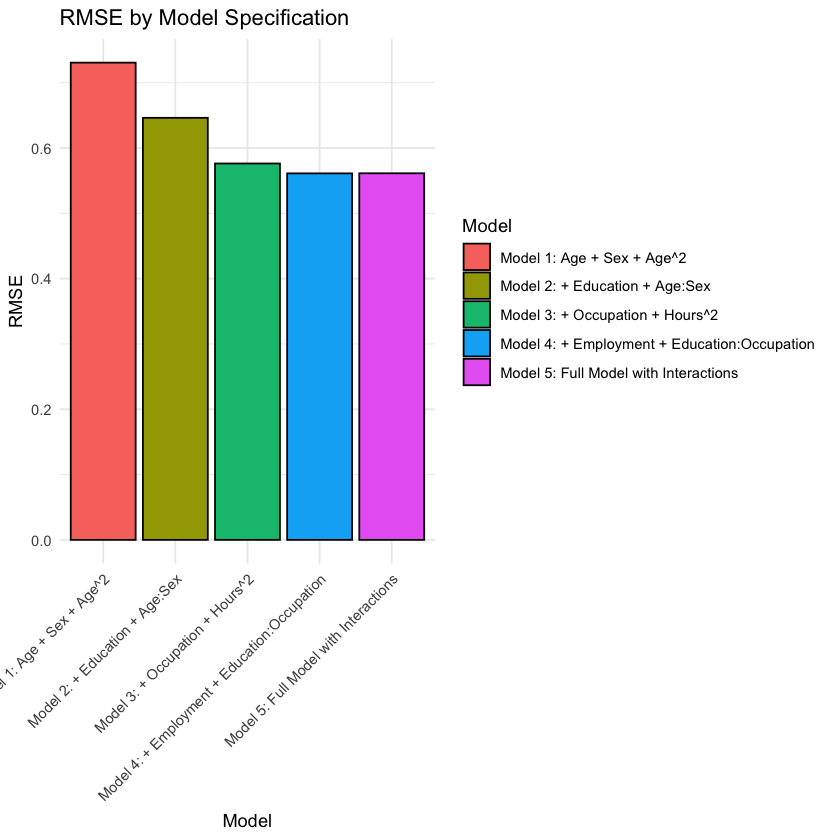

In [30]:
ggplot(results, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity", color = "black") +
  labs(title = "RMSE by Model Specification", x = "Model", y = "RMSE") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### $\to$ model 4 wins!

In [27]:
#TODO: @Lucia & @Juandi --> propose models that deliver lower RMSE 
# use same seed 555

#### c) Discussion #TODO

**IMPORTANT** $\to$ Talk about this is in-sample performance. So in reality, we are chosen the model that overfits better... (Gracias Dani Lasso)

- i. About the overall performance of the models

- ii. About the specification with the lowest prediction error

-  iii. Analysis of observations with high prediction errors in the best model


## 4.3. LOOCV

Re-fit the top models: 4 & 5

In [31]:
set.seed(555)

#  70-30 split
inTrain  <- createDataPartition(y = df$log_wage, p = 0.70, list = FALSE)
training <- df %>% filter(row_number() %in% inTrain)
testing  <- df %>% filter(!row_number() %in% inTrain)

# Model 4: Employment + Education:Occupation
form_4  <- log_wage ~ poly(age, 2) + sex + p6210 + oficio + poly(hoursWorkUsual, 2) + relab + age:sex + p6210:oficio
model_4 <- lm(form_4, data = training)
predictions_4 <- predict(model_4, newdata = testing)
score4a <- calculate_rmse(testing$log_wage, predictions_4)

# Model 5: Full Model with Interactions
form_5 <- log_wage ~ poly(age, 2) + sex + p6210 + oficio + poly(hoursWorkUsual, 2) + relab + age:sex + p6210:oficio + relab:hoursWorkUsual
model_5 <- lm(form_5, data = training)
predictions_5 <- predict(model_5, newdata = testing)
score5a <- calculate_rmse(testing$log_wage, predictions_5)


In [32]:
# LOOCV setup (using Caret)
ctrl <- trainControl(method = "LOOCV")

# LOOCV for Model 4
model_4c <- train(form_4, data = df, method = 'lm', trControl = ctrl)
score4c <- RMSE(model_4c$pred$pred, df$log_wage)

# LOOCV for Model 5
model_5c <- train(form_5, data = df, method = 'lm', trControl = ctrl)
score5c <- RMSE(model_5c$pred$pred, df$log_wage)

# results
comparison_results <- data.frame(
  Model = c("Model 4: Test Set", "Model 4: LOOCV", 
            "Model 5: Test Set", "Model 5: LOOCV"),
  RMSE = c(score4a, score4c, score5a, score5c)
)

print(comparison_results)

## Runtime: 4.5 minutes

              Model      RMSE
1 Model 4: Test Set 0.5469061
2    Model 4: LOOCV 0.5595627
3 Model 5: Test Set 0.5463841
4    Model 5: LOOCV 0.5593856


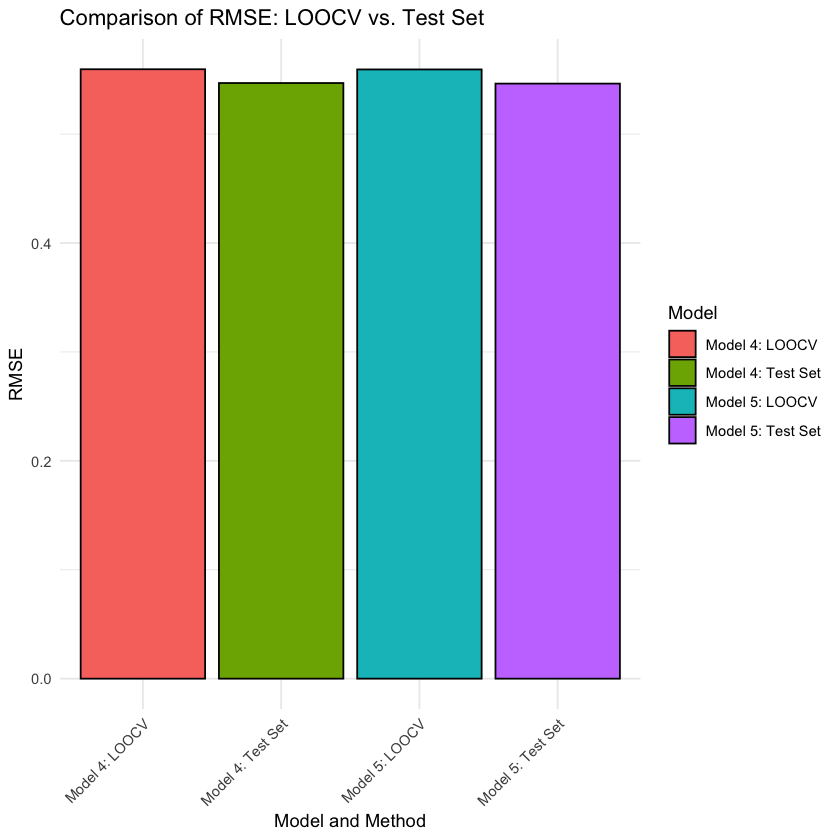

In [33]:
ggplot(comparison_results, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity", color = "black") +
  labs(title = "Comparison of RMSE: LOOCV vs. Test Set",
       x = "Model and Method", y = "RMSE") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Well, we are not overfitting much. If we were, MSE in LOOCV would be much lower than the test set.

### *BONUS:* Using Leverage Values
Much faster and same results

In [34]:
# model 4
form_4 <- log_wage ~ poly(age, 2) + sex + p6210 + oficio + poly(hoursWorkUsual, 2) + relab + age:sex + p6210:oficio
full_model_4 <- lm(form_4, data = df)

X_4 <- model.matrix(full_model_4)
y_4 <- model.response(model.frame(full_model_4))

# (X'X)
A_4 <- solve(t(X_4) %*% X_4)

# leverage values and 1/(1 - h_i)
vec_4 <- 1 / (1 - hatvalues(full_model_4))

# number of obs
N_4 <- nrow(X_4)
LOO_4 <- numeric(N_4)

# loop over observations to calculate LOOCV error
for (i in 1:N_4) {
  new_beta_4 <- full_model_4$coefficients - vec_4[i] * full_model_4$residuals[i] * A_4 %*% as.vector(X_4[i, ])
  
  # get the prediction error for the i-th observation
  new_error_4 <- (y_4[i] - (X_4[i, ] %*% new_beta_4))^2
  LOO_4[i] <- new_error_4
}

# get the LOOCV RMSE for Model 4
looCV_error_4 <- mean(LOO_4)
rmse_4_loocv <- sqrt(looCV_error_4)
print(paste("Model 4 LOOCV RMSE:", rmse_4_loocv))

## repeat for model 5

# model 5
form_5 <- log_wage ~ poly(age, 2) + sex + p6210 + oficio + poly(hoursWorkUsual, 2) + relab + age:sex + p6210:oficio + relab:hoursWorkUsual
full_model_5 <- lm(form_5, data = df)

X_5 <- model.matrix(full_model_5)
y_5 <- model.response(model.frame(full_model_5))

# (X'X)
A_5 <- solve(t(X_5) %*% X_5)

# leverage values and 1/(1 - h_i)
vec_5 <- 1 / (1 - hatvalues(full_model_5))

N_5 <- nrow(X_5)
LOO_5 <- numeric(N_5)

# loop over each observation to calculate LOOCV error
for (i in 1:N_5) {
  new_beta_5 <- full_model_5$coefficients - vec_5[i] * full_model_5$residuals[i] * A_5 %*% as.vector(X_5[i, ])
  
  # Calculate the prediction error for the i-th observation
  new_error_5 <- (y_5[i] - (X_5[i, ] %*% new_beta_5))^2
  LOO_5[i] <- new_error_5
}

# LOOCV RMSE for Model 5
looCV_error_5 <- mean(LOO_5)
rmse_5_loocv <- sqrt(looCV_error_5)
print(paste("Model 5 LOOCV RMSE:", rmse_5_loocv))

## runtime: 0.2s
## conclusion: I love OLS

[1] "Model 4 LOOCV RMSE: 0.559562664107529"
[1] "Model 5 LOOCV RMSE: 0.559385627017019"


## Link between LOOCV and Leverage Values

Previously we conducted LOOCV to estimate the prediction error of our models using leverages influence statistics, specifically the leverage values (`hatvalues`) and residuals, to efficiently compute the LOOCV errors without explicitly refitting the model `N` times. This approach is much faster and computationally efficient, especially for large datasets.

- The leverage value of an observation, denoted as $h_i$, measures the influence that a data point has on its own fitted value. It's derived from the diagonal elements of the hat matrix (also known as the projection matrix $P$)

$$
H = X(X'X)^{-1}X' 
$$

where $X$ is the matrix of predictors.

- High leverage values $\implies$ the observation has a large influence on the fitted value and can significantly affect the regression coefficients.

In LOOCV, each observation is left out once, the model is refitted, and the prediction error for that observation is calculated. However, refitting the model each time is computationally expensive. Instead of refitting, we use influence statistics by adjusting the coefficients $\beta_{\text{new}}$ without fully refitting the model. We can do this by using the formula:
$$
\beta_{\text{new}} = \beta - \frac{r_i}{1 - h_i} \cdot A \cdot X_i
$$

where:

- $\beta$: Original regression coefficients
- $r_i$: Residual of the  $i$-th observation
- $h_i$: Leverage of the $i$-th observatin (diagonal elements of $H$)
- $A$: Inverse of $X'X$, used to update coefficients


Using the updated coefficients (`new_beta`), the new prediction error (`new_error`) for each observation can be computed without needing to refit the model, making this approach efficient.